In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 
import ast
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm_notebook
from keras import backend as K
from keras import Model
from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.utils.training_utils import multi_gpu_model

from keras.optimizers import SGD
from keras import callbacks
from data import *
from keras_helper import *

from keras.applications import Xception
from keras.applications.xception import preprocess_input

In [2]:
#TOT = 35534421
TOT = 46613580 - 340000
EPOCHS = 50
size = 71
batchsize = 340
lw = 6
channel = 3
STEPS = TOT / EPOCHS / batchsize
NCATS = 340
mixup = 0
center = False
optimizer = 'adam'
cb = 'snap'

In [3]:
K.clear_session()
# model = Xception(input_shape=(size, size, channel), weights=None, classes=NCATS)
model = Xception(input_shape=(None,None,3), weights=None, classes=NCATS)

if optimizer == 'sgd':
    opt = SGD(0.002, momentum=0.9, nesterov=True)
    opt = NormalizedOptimizer(opt, normalization='l2')
elif optimizer == 'adam':
    opt = Adam(lr=0.001)

# model = multi_gpu_model(model, gpus=2)

model.load_weights('models/xception71_time_lw6_balance_0_adam.model')

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
valid_df = pd.read_csv('../input/valid_raw.csv')
np_classes = np.load('../input/classes.npy')
cat2id = {cat.replace(' ', '_'):k for k, cat in enumerate(np_classes)}
valid_df.word = valid_df.word.apply(lambda x: cat2id[x.replace(' ', '_')])
y_valid = keras.utils.to_categorical(valid_df.word, num_classes=NCATS)
x_valid = df_to_image_array_timeencoding(valid_df, size, lw=lw, preprocess_input=preprocess_input)

x shape (34000, 71, 71, 3) x max 255


In [5]:
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 71, 71, 3) (34000, 340)
Validation array memory 1.92 GB


In [6]:
train_datagen = image_detail_generator(size=size, batchsize=batchsize, lw=lw, 
                                   preprocess_input=preprocess_input)

In [13]:
model_prefix = 'xception{}_time_lw{}_balance_{}_{}'.format(size, lw, mixup, optimizer, cb)
if center:
    model_prefix += '_center'

print(model_prefix)
check_path = "./models/{}.model".format(model_prefix)
fold = 9
if cb == 'raw':
    callbks = [
        ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=5,
                          min_delta=0.005, mode='max', cooldown=3, verbose=1),
        callbacks.ModelCheckpoint(check_path,
                                    monitor='val_top_3_accuracy', 
                                    mode = 'max', 
                                  save_best_only=True, save_weights_only=True,
                                  verbose=1),
        callbacks.TensorBoard(log_dir='./log/{}'.format(model_prefix)),
        EarlyStopping(monitor='val_top_3_accuracy', mode='max',patience=20, verbose=1)
    ]
elif cb == 'snap':
    snapshot = SnapshotCallbackBuilder(nb_epochs=EPOCHS,
                                       nb_snapshots=2,
                                       size = size,
                                       init_lr=1e-3, 
                                       fold=fold)
 
    callbks = snapshot.get_callbacks(model_prefix = model_prefix)

xception71_time_lw6_balance_0_adam


In [ ]:
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbks,
    workers = 1,
    max_queue_size=100,7
    use_multiprocessing=False
)

Stochastic weight averaging selected for last 5 epochs.
gen inited
Epoch 1/50
2722/2721 [==============================] - 3149s 1s/step - loss: 0.6206 - categorical_crossentropy: 0.6206 - categorical_accuracy: 0.8360 - top_3_accuracy: 0.9426 - val_loss: 0.7279 - val_categorical_crossentropy: 0.7279 - val_categorical_accuracy: 0.8126 - val_top_3_accuracy: 0.9300

Epoch 00001: val_top_3_accuracy improved from -inf to 0.93003, saving model to ./models/xception71_time2_lw6_balance_0_sgd.model
Epoch 2/50
2722/2721 [==============================] - 3245s 1s/step - loss: 0.6137 - categorical_crossentropy: 0.6137 - categorical_accuracy: 0.8379 - top_3_accuracy: 0.9433 - val_loss: 0.6600 - val_categorical_crossentropy: 0.6600 - val_categorical_accuracy: 0.8299 - val_top_3_accuracy: 0.9377

Epoch 00002: val_top_3_accuracy improved from 0.93003 to 0.93774, saving model to ./models/xception71_time2_lw6_balance_0_sgd.model
Epoch 3/50
2722/2721 [==============================] - 3420s 1s/step - lo

In [4]:
test = pd.read_csv('../input/test_raw.csv')
test.head()
x_test = df_to_image_array_timeencoding(test, size, lw=lw, 
                              preprocess_input=preprocess_input)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

np_classes = np.load('../input/classes.npy')
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(np_classes)}


x shape (112199, 71, 71, 3) x max 255
(112199, 3) (112199, 71, 71, 3)
Test array memory 6.32 GB


In [17]:
def doodle_predict(model, model_path, x_test):
    model.load_weights(model_path)

    test_predictions = model.predict(x_test, batch_size=128, verbose=1)
    
    x_test_flip = np.zeros_like(x_test)
    for i in tqdm_notebook(range(len(x_test))):
        x_test_flip[i] = cv2.flip(x_test[i], flipCode = 1)
    
    test_predictions_flip = model.predict(x_test_flip, batch_size=128, verbose=1)
    test_predictions = test_predictions * 0.5 + test_predictions_flip * 0.5
    
    np.save('../result/pre_{}.npy'.format(model_prefix), test_predictions)
    top3 = preds2catids(test_predictions)
    top3cats = top3.replace(id2cat)
    test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
    submission = test[['key_id', 'word']]

    import kaggle_util
    kaggle_util.save_result(submission,  
                            '../result/{}.csv'.format(model_prefix), 
                            'quickdraw-doodle-recognition', 
                            send=True, index=False)

In [18]:
doodle_predict(model, check_path, x_test)

112199/112199 [==============================] - 50s 448us/step
save result


In [ ]:
valid_df = pd.read_csv('../input/valid_raw.csv')
np_classes = np.load('../input/classes.npy')
cat2id = {cat.replace(' ', '_'):k for k, cat in enumerate(np_classes)}
valid_df.word = valid_df.word.apply(lambda x: cat2id[x.replace(' ', '_')])
y_valid = keras.utils.to_categorical(valid_df.word, num_classes=NCATS)
x_valid = df_to_image_array_timeencoding(valid_df, size, lw=lw, preprocess_input=preprocess_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


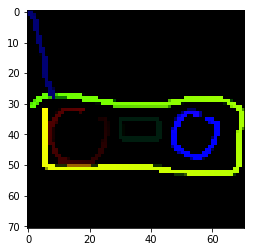

In [5]:
plt.imshow(x_test[0])

In [8]:
plt.imshow(cv2.flip(x_test[0:1], flipCode = 1))

error: OpenCV(3.4.3) /io/opencv/modules/core/src/copy.cpp:740: error: (-215:Assertion failed) _src.dims() <= 2 in function 'flip'


In [9]:
x_test_flip = np.zeros_like(x_test)

In [10]:
for i in range(len(x_test)):
    x_test_flip[i] = cv2.flip(x_test[i], flipCode = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

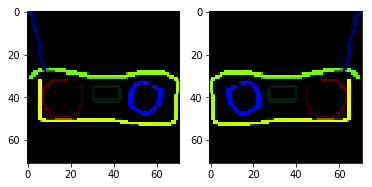

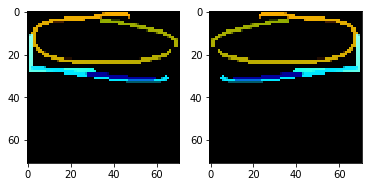

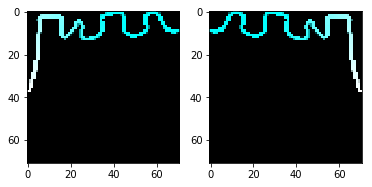

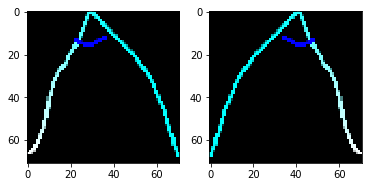

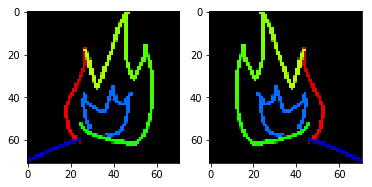

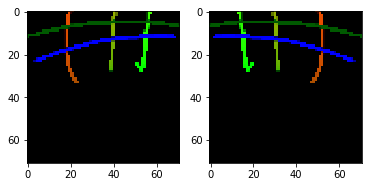

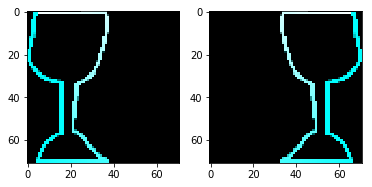

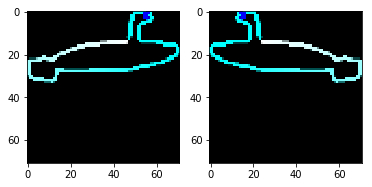

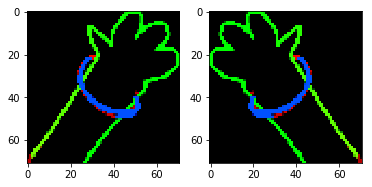

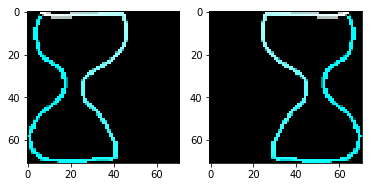

In [11]:
for i in range(10):
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(x_test[i])
    axs[1].imshow(x_test_flip[i])